In [24]:
import or_gym
from or_gym import utils
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ray
from ray import tune
from ray.rllib import agents
import os
import pickle

In [17]:
env_name = 'InvManagement-v2'
ray_path = '/home/christian/ray_results/PPO'
iv2_paths = [p for p in os.listdir(ray_path) if env_name in p]
iv2_paths

['PPO_InvManagement-v2_ea14d_00001_1_lr=0.0001,vf_loss_coeff=1.0_2020-11-04_18-01-36',
 'PPO_InvManagement-v2_5c8d9_00008_8_lr=1e-06,vf_loss_coeff=0.1_2020-11-04_12-42-49',
 'PPO_InvManagement-v2_5c8d9_00002_2_lr=1e-06,vf_loss_coeff=1.0_2020-11-04_12-38-45',
 'PPO_InvManagement-v2_ea14d_00003_3_lr=1e-05,vf_loss_coeff=0.5_2020-11-05_04-18-55',
 'PPO_InvManagement-v2_5c8d9_00000_0_lr=1e-05,vf_loss_coeff=1.0_2020-11-04_12-37-31',
 'PPO_InvManagement-v2_ea14d_00005_5_lr=1e-06,vf_loss_coeff=0.5_2020-11-05_09-10-11',
 'PPO_InvManagement-v2_ea14d_00000_0_lr=1e-05,vf_loss_coeff=1.0_2020-11-04_12-55-48',
 'PPO_InvManagement-v2_ea14d_00002_2_lr=1e-06,vf_loss_coeff=1.0_2020-11-04_23-12-13',
 'PPO_InvManagement-v2_5c8d9_00006_6_lr=1e-05,vf_loss_coeff=0.1_2020-11-04_12-41-27',
 'PPO_InvManagement-v2_5c8d9_00004_4_lr=0.0001,vf_loss_coeff=0.5_2020-11-04_12-40-05',
 'PPO_InvManagement-v2_5c8d9_00007_7_lr=0.0001,vf_loss_coeff=0.1_2020-11-04_12-42-09',
 'PPO_InvManagement-v2_5c8d9_00001_1_lr=0.0001,vf_l

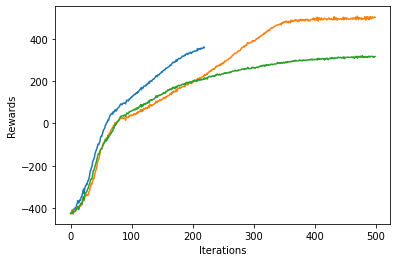

In [34]:
plt.figure()

for p in iv2_paths:
    d_path = os.path.join(ray_path, p)
    files = os.listdir(d_path)
    if 'error.txt' in files:
        continue
    data = pd.read_csv(os.path.join(d_path, 'progress.csv'))
    
    plt.plot(data['episode_reward_mean'])
    
plt.ylabel('Rewards')
plt.xlabel('Iterations')
plt.show()

In [30]:
data.head()

,episode_reward_max,episode_reward_min,episode_reward_mean,episode_len_mean,episodes_this_iter,num_healthy_workers,timesteps_total,done,episodes_total,training_iteration,...,perf/ram_util_percent,info/learner/default_policy/cur_kl_coeff,info/learner/default_policy/cur_lr,info/learner/default_policy/total_loss,info/learner/default_policy/policy_loss,info/learner/default_policy/vf_loss,info/learner/default_policy/vf_explained_var,info/learner/default_policy/kl,info/learner/default_policy/entropy,info/learner/default_policy/entropy_coeff
0,-351.245886,-501.338931,-423.922135,30.0,132,4,4000,False,132,1,...,53.360714,0.2,1.000000e-06,91418.41,-0.009114,91418.410,-0.000198,0.012413,14.940580,0.0
1,-358.189519,-486.428346,-424.642147,30.0,132,4,8000,False,264,2,...,53.537736,0.2,1.000000e-06,86746.11,-0.009375,86746.100,-0.000486,0.010342,14.876517,0.0
2,-365.944476,-508.743409,-425.350916,30.0,136,4,12000,False,400,3,...,53.601852,0.2,1.000000e-06,82685.20,-0.008455,82685.200,-0.000987,0.012006,14.848914,0.0
3,-354.139419,-478.260095,-414.477645,30.0,132,4,16000,False,532,4,...,53.666667,0.2,1.000000e-06,72868.96,-0.011248,72868.980,-0.001405,0.014659,14.695346,0.0
4,-358.792648,-499.883956,-427.490289,30.0,132,4,20000,False,664,5,...,53.690741,0.2,1.000000e-06,73347.08,-0.015172,73347.086,-0.001791,0.011512,14.625069,0.0


In [23]:
def load_policy(path, checkpoint_id="500", pickle=True):
    if pickle:
        with open(f"{path}/params.pkl", "rb") as read_file:
            config = pickle.load(read_file)
    else:
        with open(f"{path}/params.json", "r") as read_file:
            config = json.load(read_file)
    split_path = path.split('/')
    algo = [j for i, j in enumerate(split_path) if split_path[i-1] == 'ray_results'][0].lower()
    if hasattr(agents, algo):
        agent = getattr(agents, algo)
    
    trainer = getattr(agent, algo.upper() + 'Trainer')(config, env=create_env(config['env']))
    trainer.restore(f"{path}/checkpoint_{checkpoint_id}/checkpoint-{checkpoint_id}")
    return trainer

In [25]:
?tune.run